# Analysis of the Ethereum Blockchain Arbitrages

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

# Data Collection

The data consists of a list of arbitrage transactions, liquidations, block features which are stored on a postgres db.
Additionally, general features of the blockchain e.g. number of protocol usages in the transactions are stored in the db directory.
The arbitrage transactions were collected using calls to multiple Erigon RPC endpoints.

The first collection of data is from block 15200000 to 15500000 or from Jul-23-2022 04:32:35 PM +UTC to Sep-09-2022 01:39:42 AM +UTC.
These blocks are pre-merge blocks. The next collection will analyse the post-merge blocks.

First, we must connect to our database.

In [2]:
# Connect to db
from sqlalchemy import create_engine, text
from db import get_inspect_database_uri

conn = create_engine(get_inspect_database_uri()).connect()

# Arbitrage Analysis

## Data Loading and Preprocessing

In [3]:
AFTER_BLOCK = 15600000
BEFORE_BLOCK = 15900000

In [4]:
query = f"SELECT * FROM arbitrages WHERE block_number BETWEEN {AFTER_BLOCK} AND {BEFORE_BLOCK}"
arb_df = pd.DataFrame(conn.execute(text(query)))

In [5]:
arb_df.set_index('id', inplace=True)
arb_df['timestamp'] = pd.to_datetime(arb_df['timestamp'])
arb_df = arb_df.sort_values(by=['block_number', 'block_position'])

In [6]:
arb_df.head()

,transaction_hash,block_number,timestamp,account_address,status,contracts_address,input_tokens_address,input_tokens_amount,output_tokens_address,output_tokens_amount,protocols,gas_price,gas_usage,block_position,profit_amount
id,,,,,,,,,,,,,,,
114231,0xe9f4d0494afaa037f8fb5b27e667cab498a9a5133831...,15600003,2022-09-24 05:12:59,0xed77777586d73c58eb4d6bebdf9c85c2d5f56c2d,True,"{0x351c3702414c0f1d8acb0156fdc20aeda8d07a8f,0x...","{0xc02aaa39b223fe8d0a0e5c4f27ead9083c756cc2,0x...","{358328538408668400,1017715809393254900,418284...","{0x27c70cd1946795b66be9d954418546998b546634,0x...","{1017715809393254900,4182843831752633000000000...",{uniswap_v2},697885,55140,6,1.550410e+15
114232,0xe9f4d0494afaa037f8fb5b27e667cab498a9a5133831...,15600003,2022-09-24 05:12:59,0xed77777586d73c58eb4d6bebdf9c85c2d5f56c2d,True,"{0x44b1198f4742d05902a07c4ecaa97b2b9fa8954b,0x...","{0xc02aaa39b223fe8d0a0e5c4f27ead9083c756cc2,0x...","{89670196305996140,465697889912901100000000}","{0xd2877702675e6ceb975b4a1dff9fb7baf4c91ea9,0x...","{465697889912901100000000,90741252122200770}",{uniswap_v2},335057,50011,6,1.071056e+15
114233,0x691170d369615cd1de3ee1673d77a54114358bdbc537...,15600013,2022-09-24 05:14:59,0x7ed7382d0ecfee9bf1085671cce4b0a5774a6e89,True,"{0x0d0d65e7a7db277d3e0f5e1676325e75f3340455,0x...","{0xc02aaa39b223fe8d0a0e5c4f27ead9083c756cc2,0x...","{243369799421039070,2350505264864055300000}","{0xa3bed4e1c75d00fa6f4e5e6922db7261b5e9acd2,0x...","{2350505264864055300000,245780521327393400}",{uniswap_v2},164344,48110,108,2.410722e+15
114234,0x0a45d8f6ab24c02c29589e60d9d411e1b378282958b5...,15600016,2022-09-24 05:15:35,0x30a123cbf79fdb6ac10556b20531545de0da652b,True,"{0x2f62f2b4c5fcd7570a709dec05d68ea19c82a9ec,0x...","{0xc02aaa39b223fe8d0a0e5c4f27ead9083c756cc2,0x...","{1168987961394070000,1029483675999711700000,13...","{0x9813037ee2218799597d83d4a5b6f3b6778218d9,0x...","{1029483675999711700000,1359399804584004300000...","{uniswap_v2,uniswap_v3}",74102,32125,28,1.471711e+15
114235,0x1a7fff673f259848527f49ac237b40b6af9281e06d17...,15600016,2022-09-24 05:15:35,0xa1006d0051a35b0000f961a8000000009ea8d2db,True,"{0x4087d0e6e513f260de87408bee9334a5742cfdf4,0x...","{0xc02aaa39b223fe8d0a0e5c4f27ead9083c756cc2,0x...","{49010605532480410,4795520712435.0,65919855.0,...","{0x19e2a43fbbc643c3b2d9667d858d49cad17bc2b5,0x...","{4795520712435.0,65919855.0,53556855113.0,5056...",{uniswap_v2},339694,51960,84,1.554649e+15


In [7]:
arb_df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 96630 entries, 114231 to 210870
Data columns (total 15 columns):
 #   Column                 Non-Null Count  Dtype         
---  ------                 --------------  -----         
 0   transaction_hash       96630 non-null  object        
 1   block_number           96630 non-null  int64         
 2   timestamp              96630 non-null  datetime64[ns]
 3   account_address        96630 non-null  object        
 4   status                 96630 non-null  bool          
 5   contracts_address      96630 non-null  object        
 6   input_tokens_address   96630 non-null  object        
 7   input_tokens_amount    96630 non-null  object        
 8   output_tokens_address  96630 non-null  object        
 9   output_tokens_amount   96630 non-null  object        
 10  protocols              96630 non-null  object        
 11  gas_price              96630 non-null  int64         
 12  gas_usage              96630 non-null  int64         


## Status Analysis

Get the success rate of each address and protocol.

In [8]:
def count_features_grouped_by(df: pd.DataFrame, condition: str, _by: [str], features: [str]) -> pd.DataFrame:
    return df.loc[eval(condition)].groupby(by=_by).count().reset_index()[features]

### By Address

Get the success rate of each address

In [9]:
address_success_rate = arb_df.groupby('account_address')['status'].mean()
print('Success rate of each address:')
address_success_rate.head()

Success rate of each address:


account_address
0x000000000000660def84e69995117c0176ba446e    0.777778
0x0000000000007f150bd6f54c40a34d7c3d5e9f56    1.000000
0x0000000000036414940324055c43e75f56b7d016    1.000000
0x00000000000747d525e898424e8774f7eb317d00    1.000000
0x00000000000a47b1298f18cf67de547bbe0d723f    0.932432
Name: status, dtype: float64

### By Protocol
Get the success rate of each address


In [10]:
# Split the protocols column into separate columns for each protocol
protocols_df = arb_df["protocols"].str.replace("[{}]", "", regex=True).str.get_dummies(sep=",")

# Concatenate the status column and the protocol columns
merged_df = pd.concat([arb_df["status"], protocols_df], axis=1)

# Calculate the success rate for each protocol
rates_df = merged_df.mean()
rates_df = rates_df.drop("status")

rates_df

balancer_v1    0.091028
bancor         0.000135
curve          0.003529
uniswap_v2     0.828190
uniswap_v3     0.500704
dtype: float64

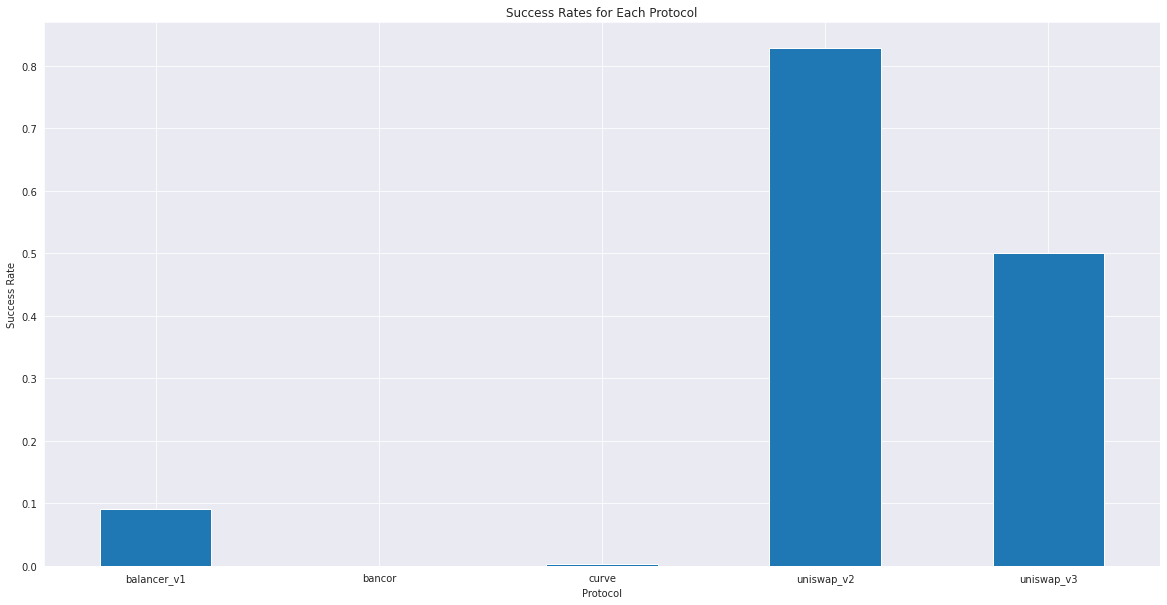

In [11]:
plt.figure(figsize=(20, 10))
rates_df.plot(kind="bar", rot=0)
plt.title("Success Rates for Each Protocol")
plt.xlabel("Protocol")
plt.ylabel("Success Rate")
plt.show()

## Gas Usage Analysis

### Distribution

### Average gas usage per block
Compare average gas price for arbitrage transactions in each block with the total average gas price of that block.

First, load the blocks' data.

In [12]:
# TODO: Log-transformation for heavy-tailed features
query = f"SELECT * FROM blocks WHERE block_number BETWEEN {AFTER_BLOCK} AND {BEFORE_BLOCK}"
block_df = pd.DataFrame(conn.execute(text(query)))
block_df = block_df.sort_values(by=['block_number'])
block_df

,block_number,avg_gas_price,avg_gas_usage
0,15600000,9.784476e+09,157081.127907
1,15600001,9.313270e+09,108637.623853
2,15600002,9.849113e+09,272353.550725
3,15600003,9.025566e+09,154485.951807
4,15600004,9.780545e+09,149676.708955
...,...,...,...
299995,15899995,1.653963e+10,180300.406504
299996,15899996,1.404016e+10,204445.519380
299997,15899997,1.337028e+10,176342.420732
299998,15899998,1.300481e+10,188917.658228


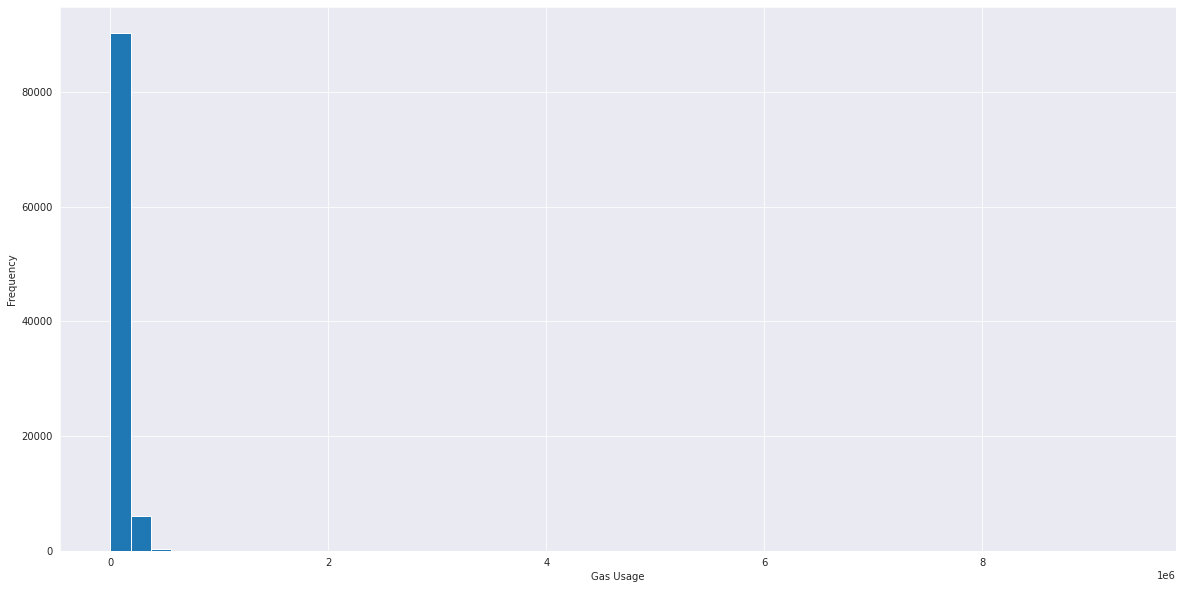

In [13]:
# Gas usage distribution

plt.figure(figsize=(20, 10))
plt.hist(arb_df['gas_usage'], bins=50)
plt.xlabel('Gas Usage')
plt.ylabel('Frequency')
plt.show()

### Compared with all transactions

In [14]:
avg_gas_per_block = arb_df.groupby('block_number')['gas_usage'].mean()

In [15]:
# merge the average gas usage per block with the blocks_df dataframe
merged_df = pd.merge(block_df, avg_gas_per_block, on='block_number', how='inner')
merged_df.sort_values(by='block_number')

,block_number,avg_gas_price,avg_gas_usage,gas_usage
0,15600003,9.025566e+09,154485.951807,52575.5
1,15600013,7.300172e+09,123946.525180,48110.0
2,15600016,1.267718e+10,143586.754902,42042.5
3,15600020,7.834227e+09,214153.184426,37500.5
4,15600024,5.959430e+09,165272.597598,180239.0
...,...,...,...,...
62241,15899962,1.394458e+10,520136.868421,137443.0
62242,15899970,1.422303e+10,196464.351852,32879.0
62243,15899983,1.576475e+10,147598.872881,102803.0
62244,15899987,1.802780e+10,295088.930070,49772.0


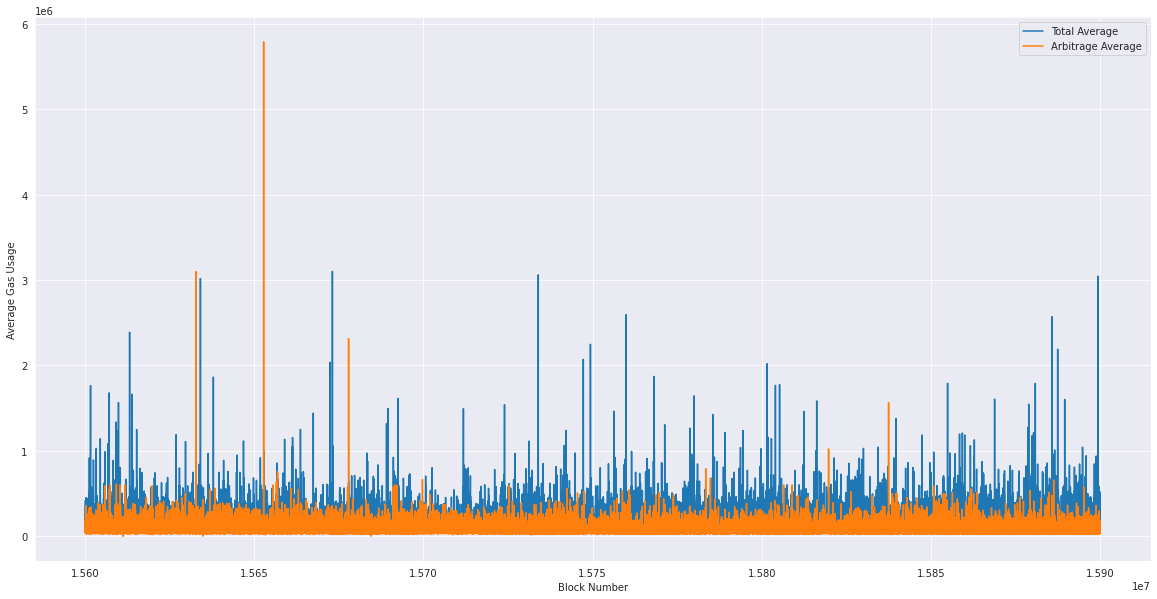

In [16]:
# plot the comparison of average gas usage per block with total average
plt.figure(figsize=(20, 10))
plt.plot(merged_df['block_number'], merged_df['avg_gas_usage'], label='Total Average')
plt.plot(merged_df['block_number'], merged_df['gas_usage'], label='Arbitrage Average')
plt.xlabel('Block Number')
plt.ylabel('Average Gas Usage')
plt.legend()
plt.show()

## Gas Price Analysis

### Distribution

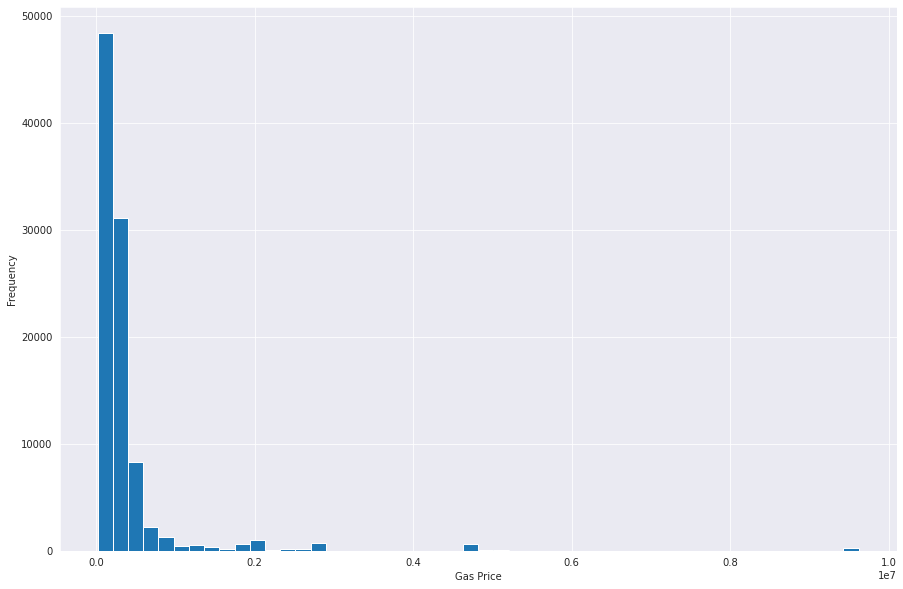

In [17]:
# Gas usage distribution

plt.figure(figsize=(15, 10))
plt.hist(arb_df['gas_price'], bins=50)
plt.xlabel('Gas Price')
plt.ylabel('Frequency')
plt.show()

### Compared with all transactions

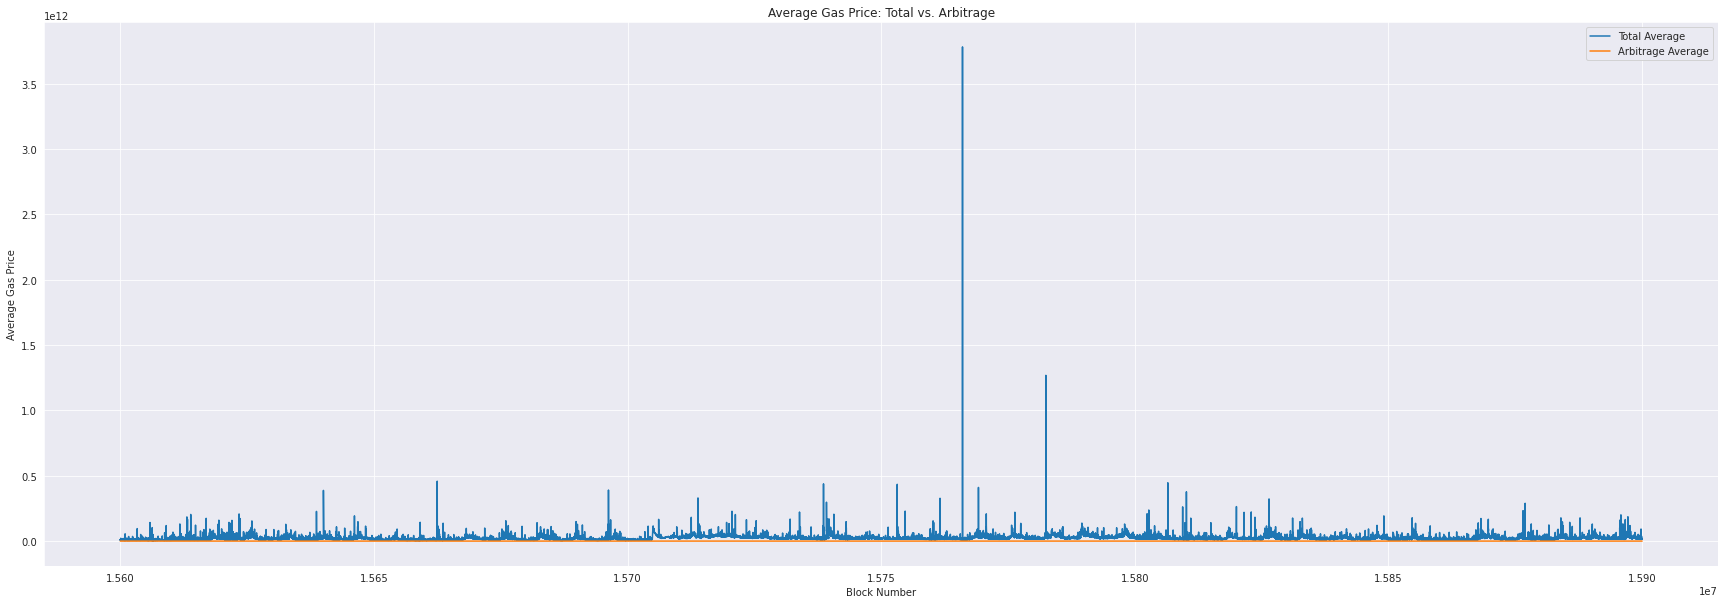

In [18]:
avg_gas_per_block = arb_df.groupby('block_number')['gas_price'].mean()

# merge the average gas price per block with the blocks_df dataframe
merged_df = pd.merge(block_df, avg_gas_per_block, on='block_number', how='inner')
merged_df.sort_values(by='block_number')

# plot the comparison of average gas usage per block with total average
plt.figure(figsize=(30, 10))
plt.plot(merged_df['block_number'], merged_df['avg_gas_price'], label='Total Average')
plt.plot(merged_df['block_number'], merged_df['gas_price'], label='Arbitrage Average')
plt.xlabel('Block Number')
plt.ylabel('Average Gas Price')
plt.title("Average Gas Price: Total vs. Arbitrage")
plt.legend()
plt.show()

# Analysis of the Tokens

In the first part, we show the most used tokens for profit in arbitrage.
Note that in an arbitrage transaction there might be several tokens involved but in the end the arbitrageur gains profit from a single token (this is the most basic analysis of arbitrage transactions, it's possible that the user gains profit from multiple tokens which occur in more complex arbitrages).

In [19]:
from collections import Counter


def _address_use(token_column: str):
    all_sets = pd.concat([arb_df[token_column]])
    all_strings = [string for set_ in all_sets for string in set_.split(',')]
    counts = Counter(all_strings)

    return pd.DataFrame(counts.values(), index=counts.keys(), columns=['count'])

In [20]:
# Replace the { and } characters in the relevant columns with an empty string using the str.replace method.

list_columns = ['contracts_address', 'input_tokens_address', 'input_tokens_amount', 'output_tokens_address',
                'output_tokens_amount', 'protocols']

for column in list_columns:
    arb_df[column] = arb_df[column].str.replace('[{}]', '', regex=True)

In [21]:
input_tokens = _address_use('input_tokens_address')
output_tokens = _address_use('output_tokens_address')

### Difference between input and output degrees of arbitrage transactions

In [22]:
any(input_tokens - output_tokens != 0)

True

The input and output degrees of the tokens are equal.

### Transaction Degree Analysis
Now, let's check the degree of arbitrage transactions i.e. the number of different tokens used in each transaction.

In [23]:
def get_transactions_degree():
    input_tokens_degree = pd.DataFrame(columns=['transaction_hash', 'degree'])
    output_tokens_degree = pd.DataFrame(columns=['transaction_hash', 'degree'])

    # Get degrees for output tokens
    output_tokens_degree['transaction_hash'] = arb_df['transaction_hash']
    output_tokens_degree['degree'] = arb_df['output_tokens_address'].str.count(',') + 1

    # Get degrees for input tokens
    input_tokens_degree['transaction_hash'] = arb_df['transaction_hash']
    input_tokens_degree['degree'] = arb_df['input_tokens_address'].str.count(',') + 1

    return input_tokens_degree, output_tokens_degree

In [24]:
tokens_degree, _ = get_transactions_degree()
tokens_degree

,transaction_hash,degree
id,,
114231,0xe9f4d0494afaa037f8fb5b27e667cab498a9a5133831...,3
114232,0xe9f4d0494afaa037f8fb5b27e667cab498a9a5133831...,2
114233,0x691170d369615cd1de3ee1673d77a54114358bdbc537...,2
114234,0x0a45d8f6ab24c02c29589e60d9d411e1b378282958b5...,3
114235,0x1a7fff673f259848527f49ac237b40b6af9281e06d17...,4
...,...,...
210866,0x7e50cb5d2120bf9150ba6bd48017662b47c67462cdd5...,2
210867,0xe3d07d67ecf2cc065f20983a25c8f574ae921d40c9a6...,2
210868,0xb53cf92d8f34ebdc2edff75206300cf1c9e6b1a23025...,2


array([[<AxesSubplot:title={'center':'degree'}>]], dtype=object)

<Figure size 1440x720 with 0 Axes>

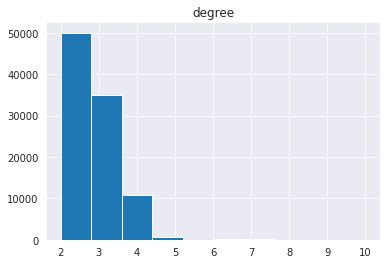

In [25]:
plt.figure(figsize=(20, 10))
tokens_degree.hist('degree')

In [26]:
from tokens.name_tags import get_name_tag


def _get_name_tags(addresses):
    _public_name_tags = {}

    for address in addresses:
        _public_name_tags[address] = get_name_tag(_address=address)

    return _public_name_tags

/usr/lib/python3/dist-packages/requests/__init__.py:89: RequestsDependencyWarning: urllib3 (1.26.15) or chardet (3.0.4) doesn't match a supported version!
  warnings.warn("urllib3 ({}) or chardet ({}) doesn't match a supported "


In [27]:
# Get the 20 most used tokens
# Todo: profits?

most_used_tokens = input_tokens.nlargest(20, input_tokens.columns[0])

token_name_tags = _get_name_tags(most_used_tokens.index)

INFO:root:Already found: Wrapped Ether
INFO:root:Already found: Centre: USD Coin
INFO:root:Already found: Tether: USDT Stablecoin
INFO:root:Already found: Wrapped BTC: WBTC Token
INFO:root:Finding 0x00c2999c8b2adf4abc835cc63209533973718eb1
INFO:root:Found NWO STATE: STATE Token
INFO:root:Already found: ShibaSwap: BONE Token
INFO:root:Already found: Maker: Dai Stablecoin
INFO:root:Already found: Shiba Inu: SHIB Token
INFO:root:Already found: Frax Finance: FRAX Token
INFO:root:Already found: Shiba Inu: LEASH Token
INFO:root:Already found: AllianceBlock: ALBT Token
INFO:root:Already found: FunFair Token
INFO:root:Already found: Terra: USTC Token
INFO:root:Already found: HEX.com: HEX Token
INFO:root:Finding 0x12b6893ce26ea6341919fe289212ef77e51688c8
INFO:root:Found Token
INFO:root:Already found: Prosper: PROS Token
INFO:root:Already found: Terra: LUNC Token
INFO:root:Finding 0x0cba60ca5ef4d42f92a5070a8fedd13be93e2861
INFO:root:Found The Protocol: THE Token
INFO:root:Already found: Vow: VOW

In [28]:
def bar(_ax, x, y, _rotation=75, _width=0.4):
    _ax.bar(x, y, width=_width)
    _ax.set_xticks(x)
    _ax.set_xticklabels(x, rotation=_rotation)

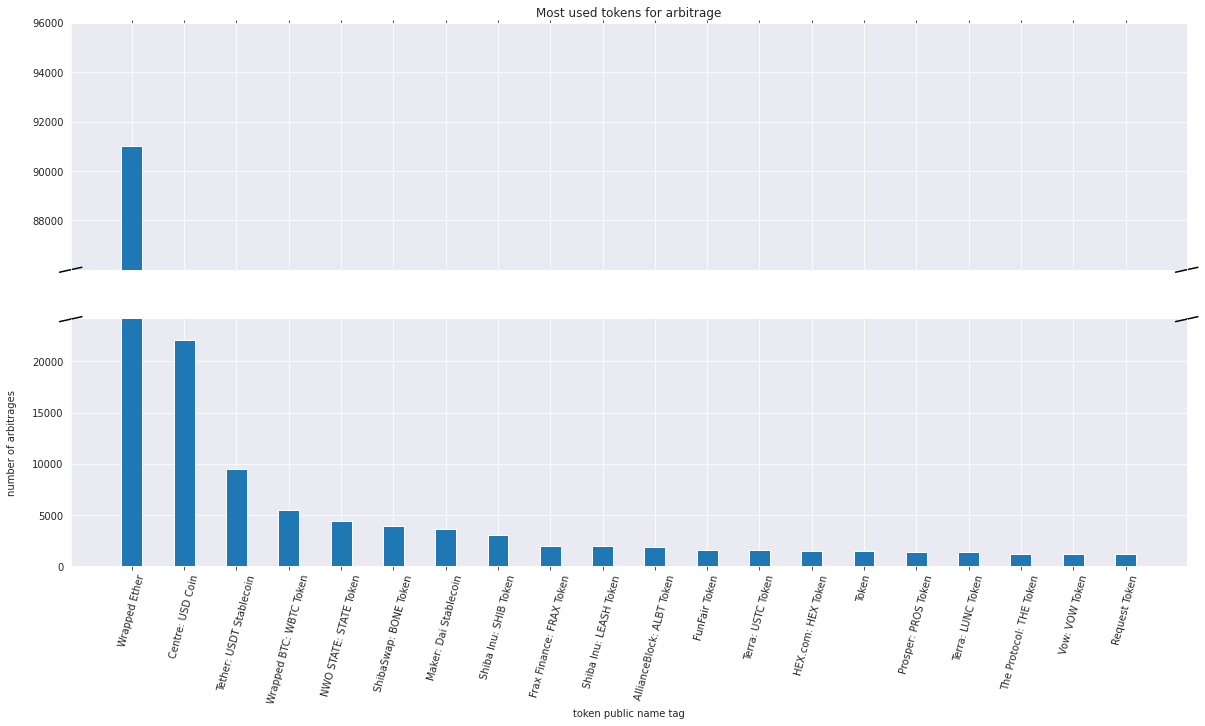

In [29]:
fig, (ax1, ax2) = plt.subplots(2, 1, figsize=(20, 10))

bar(ax1, most_used_tokens.index.map(token_name_tags), most_used_tokens.values.squeeze())
bar(ax2, most_used_tokens.index.map(token_name_tags), most_used_tokens.values.squeeze())

ax1.set_ylim(most_used_tokens.values[0] - 5000, most_used_tokens.values[0] + 5000)  # outliers only
ax2.set_ylim(0, most_used_tokens.values[1] + 2000)  # most of the data

ax1.spines['bottom'].set_visible(False)
ax2.spines['top'].set_visible(False)
ax1.xaxis.tick_top()
ax1.tick_params(labeltop=False)  # don't put tick labels at the top
ax2.xaxis.tick_bottom()

################# Diagonal Lines #################

d = .010  # how big to make the diagonal lines in axes coordinates
kwargs = {'transform':ax1.transAxes, 'color':'k', 'clip_on':False}
ax1.plot((-d, +d), (-d, +d), **kwargs)  # top-left diagonal
ax1.plot((1 - d, 1 + d), (-d, +d), **kwargs)  # top-right diagonal

kwargs.update(transform=ax2.transAxes)  # switch to the bottom axes
ax2.plot((-d, +d), (1 - d, 1 + d), **kwargs)  # bottom-left diagonal
ax2.plot((1 - d, 1 + d), (1 - d, 1 + d), **kwargs)  # bottom-right diagonal

###################################################

ax1.set_title("Most used tokens for arbitrage")

ax2.set_xlabel("token public name tag")
ax2.set_ylabel('number of arbitrages', labelpad=15)

plt.show()

The most used token is WETH. This is because arbitrageurs usually buy an arbitrage asset using ETH and gain the profit by selling them in ETH.
This might be because the WETH-TOKEN pools are more common in the exchanges.
The two latter places belong to stable coins: USDC and USDT
The three Shiba INu tokens: BONE, SHIB, and LEASH are also on top of the list.
Note that originally we only stored and counted the profit token which is usually WETH. But as mentioned before, the arbitrage opportunity is not a result of instability in WETH, rather in the instability of a certain token which is then exploited using the WETH pool.


## Active Addresses Analysis

### Most Active Addresses

In this part we take a look at the most active arbitrageurs i.e. the addresses that have the largest number of arbitrage transactions.
We can use this data along with the most profitable addresses to see if there is any relation between number of transactions and profit.

The distribution of the number of transactions by address

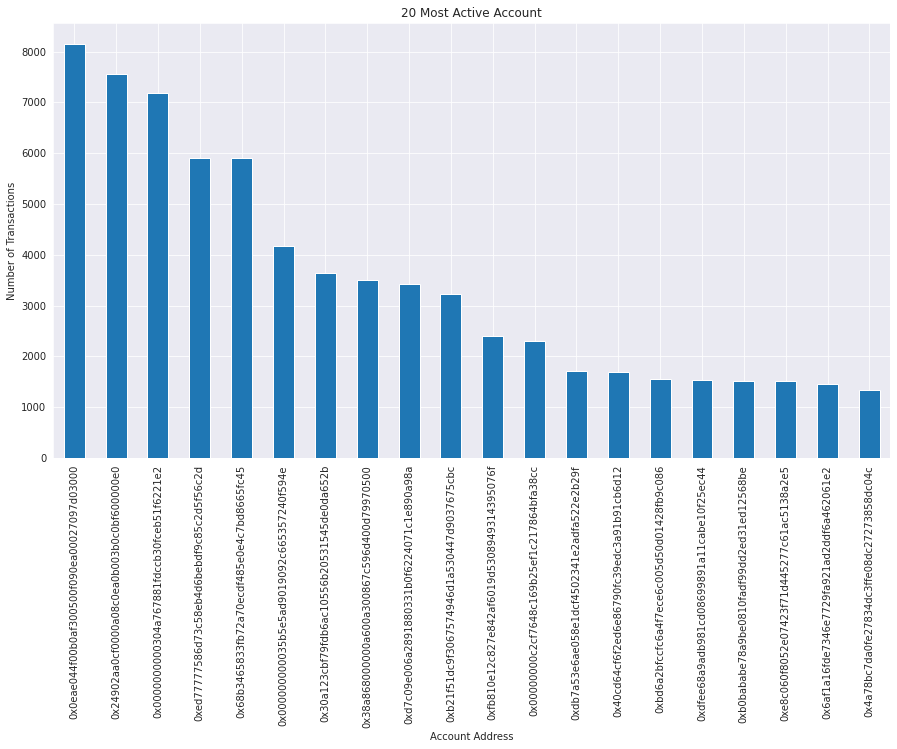

In [30]:
# Count the number of transactions for each account address
transactions_by_address = arb_df['account_address'].value_counts()

# Plot the results as a bar chart
plt.figure(figsize=(15, 8))
transactions_by_address.head(20).plot(kind='bar')
plt.title('20 Most Active Account')
plt.xlabel('Account Address')
plt.ylabel('Number of Transactions')
plt.show()

### Distribution

The distribution of the number of transactions per address.

Note: Addresses with less than 5 transactions were removed. There were around 300 accounts.

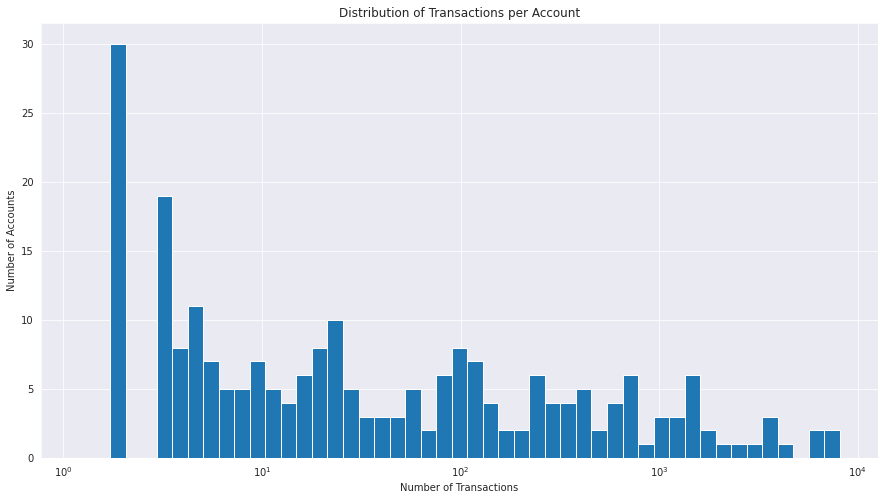

In [31]:
# Group by account address and count the number of transactions
transactions_per_account = arb_df.groupby(['account_address']).size()

# Define custom bin edges
bin_edges = np.logspace(np.log10(1), np.log10(transactions_per_account.max()), 51)

# Remove the first bin edge
bin_edges = bin_edges[1:]

# Plot the distribution of transactions per account as a histogram
plt.figure(figsize=(15, 8))
plt.hist(transactions_per_account, bins=bin_edges)
plt.xscale('log')
plt.title('Distribution of Transactions per Account')
plt.xlabel('Number of Transactions')
plt.ylabel('Number of Accounts')
plt.show()

## Ratio of arbitrage transactions

What's the ratio of arbitrage transactions to all transactions for the top 20 addresses?

In [32]:
top_addresses = transactions_by_address.head(20)
top_addresses

0x0eae044f00b0af300500f090ea00027097d03000    8150
0x24902aa0cf0000a08c0ea0b003b0c0bf600000e0    7564
0x0000000000304a767881fdccb30fceb51f6221e2    7177
0xed77777586d73c58eb4d6bebdf9c85c2d5f56c2d    5912
0x68b3465833fb72a70ecdf485e0e4c7bd8665fc45    5912
0x000000000035b5e5ad9019092c665357240f594e    4163
0x30a123cbf79fdb6ac10556b20531545de0da652b    3633
0x38a868000000a600a300867c596d400d79970500    3494
0xd7c09e006a2891880331b0f6224071c1e890a98a    3416
0xb21f51dc9f3067574946d1a530447d9037675cbc    3220
0xfb810e12c827e842af6019d5308949314395076f    2398
0x00000000c2cf7648c169b25ef1c217864bfa38cc    2297
0xdb7a53e6ae058e1dcf4502341e2adfa522e2b29f    1719
0x40cd64cf6f2ed6e86790fc39edc3a91b91cb6d12    1689
0xbd6a2bfccfc6a4f7ece6c005d50d01428fb9c086    1558
0xdfee68a9adb981cd08699891a11cabe10f25ec44    1528
0xb0bababe78a9be0810fadf99dd2ed31ed12568be    1515
0xe8c060f8052e07423f71d445277c61ac5138a2e5    1515
0x6af1a16fde7346e7729fa921ad2ddf6a462061e2    1452
0x4a78bc7da0fe27834dc3ffe08dc27

## Contracts

In [33]:
contracts_df = _address_use('contracts_address')
contracts_df

,count
0x351c3702414c0f1d8acb0156fdc20aeda8d07a8f,757
0xcf6daab95c476106eca715d48de4b13287ffdeaa,1386
0x874376be8231dad99aabf9ef0767b3cc054c60ee,565
0x44b1198f4742d05902a07c4ecaa97b2b9fa8954b,544
0x60a39010e4892b862d1bb6bdde908215ac5af6f3,1160
...,...
0x8dabe078c0b946497b00fca45a32d015473bd763,1
0x64c29aac69d3122f6e5531ceca1b753f95350af4,1
0x81ec6e89fd4e45c90ce77c9abbea3629f649c4e9,1
0x73775d1a01a7f57ffa582c76b9d08fb9200657ea,1


In [34]:
print(f"There are {len(contracts_df.index)} unique contracts involved in the transactions.")

There are 6158 unique contracts involved in the transactions.


In [35]:
top_n_contracts = 20
most_used_contracts = contracts_df.sort_values(by='count', ascending=False).head(top_n_contracts)
print(f"Top {top_n_contracts} contracts with the highest number of transactions:")
most_used_contracts

Top 20 contracts with the highest number of transactions:


,count
0x88e6a0c2ddd26feeb64f039a2c41296fcb3f5640,13096
0x4585fe77225b41b697c938b018e2ac67ac5a20c0,4683
0x11b815efb8f581194ae79006d24e0d814b7697f6,4133
0xd34d4916440dba56a5719af981e646d69c9cec0d,3710
0xcbcdf9626bc03e24f779434178a73a0b4bad62ed,3607
0x8ad599c3a0ff1de082011efddc58f1908eb6e6d8,3029
0xefb47fcfcad4f96c83d4ca676842fb03ef20a477,2936
0x60594a405d53811d3bc4766596efd80fd545a270,2211
0x1da92f6a396eeb104ad13743486b450bd8b96e62,1948
0xe5c5227d8105d8d5f26ff3634eb52e2d7cc15b50,1606


In [36]:
contract_name_tags = _get_name_tags(most_used_contracts.index)

INFO:root:Already found: Uniswap V3: USDC 3
INFO:root:Already found: Uniswap V3: WBTC 2
INFO:root:Already found: Uniswap V3: USDT 3
INFO:root:Finding 0xd34d4916440dba56a5719af981e646d69c9cec0d
INFO:root:Found Uniswap V2: STATE 2
INFO:root:Already found: Uniswap V3: WBTC
INFO:root:Already found: Uniswap V3: USDC 2
INFO:root:Already found: UniswapV2Pair
INFO:root:Already found: Uniswap V3: DAI 2
INFO:root:Finding 0x1da92f6a396eeb104ad13743486b450bd8b96e62
INFO:root:Found SushiSwap: STATE
INFO:root:Finding 0xe5c5227d8105d8d5f26ff3634eb52e2d7cc15b50
INFO:root:Found Uniswap V2: ALBT 5
INFO:root:Finding 0xe20745b629df6456dc8840ff4bc6e275459b3edf
INFO:root:Found Uniswap V2: TAMA 10
INFO:root:Already found: UniswapV2Pair
INFO:root:Already found: Uniswap V3: FUN 2
INFO:root:Finding 0x8b00ee8606cc70c2dce68dea0cefe632cca0fb7b
INFO:root:Found SushiSwap: UST
INFO:root:Finding 0x85cb2a25f2463ad78098f6607bbb95be2c5b473d
INFO:root:Found UniswapV2Pair
INFO:root:Already found: UniswapV2Pair
INFO:root:Al

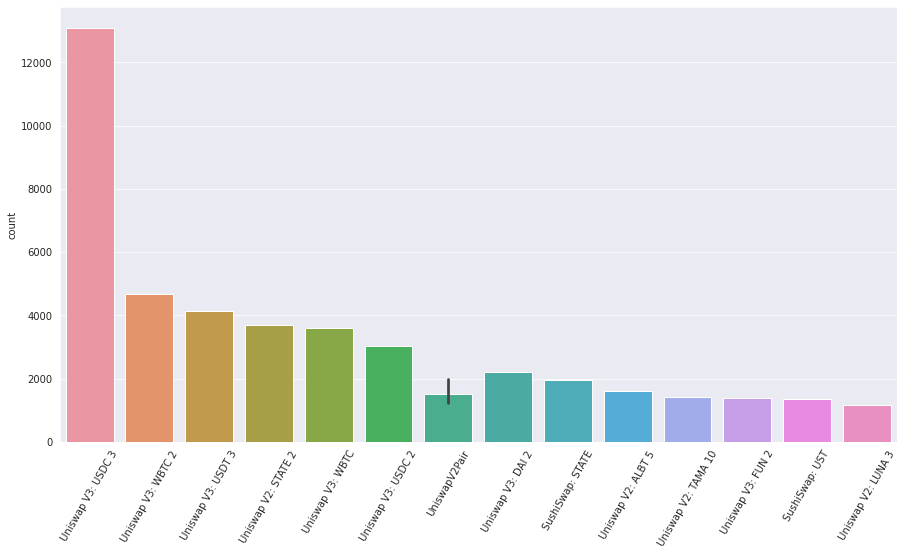

In [37]:
plt.figure(figsize=(15, 8))
sns.barplot(x=most_used_contracts.index.map(contract_name_tags), y=most_used_contracts['count'])
plt.xticks(rotation=60)
plt.show()

## Time-Series Analysis of Arbitrage Transactions

In [38]:
timed_arb_df = arb_df.set_index('timestamp', inplace=False)

daily_arb = timed_arb_df.resample('D')

In [39]:
daily_summary = daily_arb.agg({
    'transaction_hash': 'count',
    'block_number': ['min', 'max'],
    'account_address': pd.Series.nunique,
    'status': 'sum',
    'gas_price': ['min', 'max', 'mean', 'sum'],
    'gas_usage':  ['min', 'max', 'mean', 'sum'],
    'block_position': ['min', 'max', 'mean'],
    'profit_amount': ['min', 'max', 'mean', 'sum']
})

daily_summary

transaction_hash block_number           account_address status  \
                      count          min       max         nunique    sum   
timestamp                                                                   
2022-09-24             2188     15600003  15605608              87   2154   
2022-09-25             2890     15605615  15612784             126   2835   
2022-09-26             3315     15612788  15619931              97   3281   
2022-09-27             2689     15619934  15627077              92   2654   
2022-09-28             2525     15627080  15634223             101   2480   
2022-09-29             2644     15634234  15641390              97   2589   
2022-09-30             2019     15641404  15648531              97   1931   
2022-10-01             2462     15648550  15655692              85   2420   
2022-10-02             3140     15655698  15662861              83   3027   
2022-10-03             2264     15662868  15670017              86   2215   
2022-10-04             2496     15670018  15677156              80   2402   
2022-10-05             2502     15677161  15684292              86   2423   
2022-10-06             2472     15684299  15691442              96   2411   
2022-10-07             2727     15691459  15698590              94   2543   
2022-10-08             1700     15698601  15705759              92   1605   
2022-10-09             1272     15705772  15712928              81   1181   
2022-10-10             1042     15712938  15720046              73    970   
2022-10-11             1682     15720098  15727260              79   1664   
2022-10-12             1679     15727266  15734421              84   1622   
2022-10-13             3159     15734428  15741580              93   3125   
2022-10-14             2040     15741593  15748728              89   2018   
2022-10-15             1333     15748748  15755911              73   1316   
2022-10-16             2807     15755912  15763070              77   2795   
2022-10-17             2411     15763072  15770218              78   2400   
2022-10-18             2159     15770223  15777372              77   2140   
2022-10-19             1703     15777410  15784535              77   1683   
2022-10-20             1618     15784559  15791704              71   1571   
2022-10-21             1836     15791709  15798874              76   1770   
2022-10-22             1821     15798876  15806042              67   1789   
2022-10-23             1688     15806050  15813204              77   1673   
2022-10-24             1574     15813213  15820333              73   1545   
2022-10-25             2397     15820340  15827471              84   2329   
2022-10-26             2628     15827487  15834647              79   2573   
2022-10-27             2185     15834650  15841802              78   2149   
2022-10-28             1977     15841809  15848945              76   1941   
2022-10-29             3431     15848959  15856103              91   3377   
2022-10-30             2647     15856110  15863272              80   2613   
2022-10-31             2834     15863277  15870431              78   2815   
2022-11-01             2055     15870460  15877572              82   2034   
2022-11-02             2763     15877575  15884731              88   2724   
2022-11-03             2141     15884733  15891879              79   2130   
2022-11-04             3256     15891889  15899048              81   3234   
2022-11-05              459     15899053  15899993              49    455   

           gas_price                                     gas_usage           \
                 min      max           mean         sum       min      max   
timestamp                                                                     
2022-09-24     39731  9619122  399977.111517   875149920     24727   739981   
2022-09-25     47934  9619122  372082.723875  1075319072         0   609787   
2022-09-26     48674  9619158  373442.218401  1237960954     24705   5888

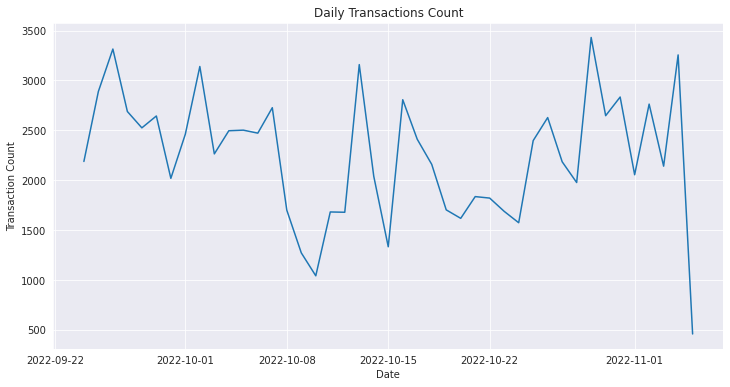

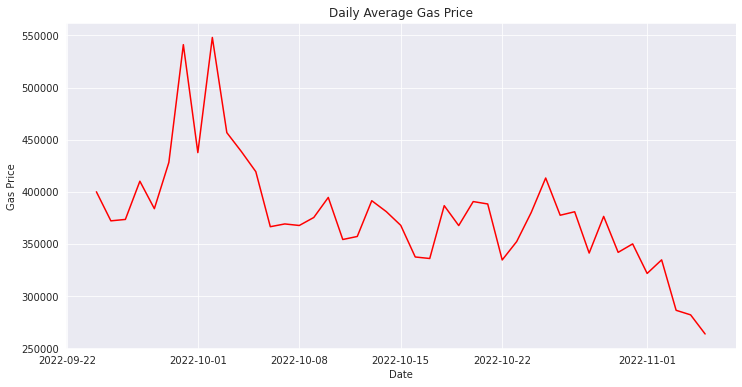

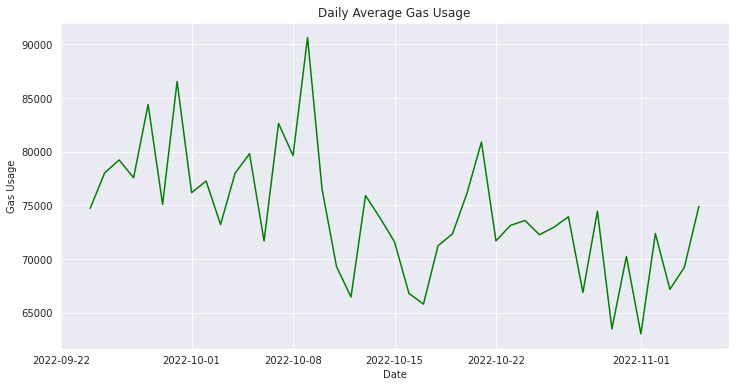

In [40]:
plt.figure(figsize=(12, 6))
plt.plot(daily_summary.index, daily_summary['transaction_hash', 'count'])
plt.xlabel('Date')
plt.ylabel('Transaction Count')
plt.title('Daily Transactions Count')

plt.figure(figsize=(12, 6))
plt.plot(daily_summary.index, daily_summary['gas_price', 'mean'], color='red')
plt.xlabel('Date')
plt.ylabel('Gas Price')
plt.title('Daily Average Gas Price')

plt.figure(figsize=(12, 6))
plt.plot(daily_summary.index, daily_summary['gas_usage', 'mean'], color='green')
plt.xlabel('Date')
plt.ylabel('Gas Usage')
plt.title('Daily Average Gas Usage')

plt.show()

## Time-Series Analysis of Accounts

In [41]:
def plot_address_activity(_address, color, _column):
    address_mask = timed_arb_df[_column].str.split(',').apply(lambda x: _address in x)
    address_df = timed_arb_df[address_mask]
    daily_tx_count = address_df.groupby(pd.Grouper(freq='D')).agg({'transaction_hash': 'count'})
    plt.plot(daily_tx_count.index, daily_tx_count['transaction_hash'], color=color)

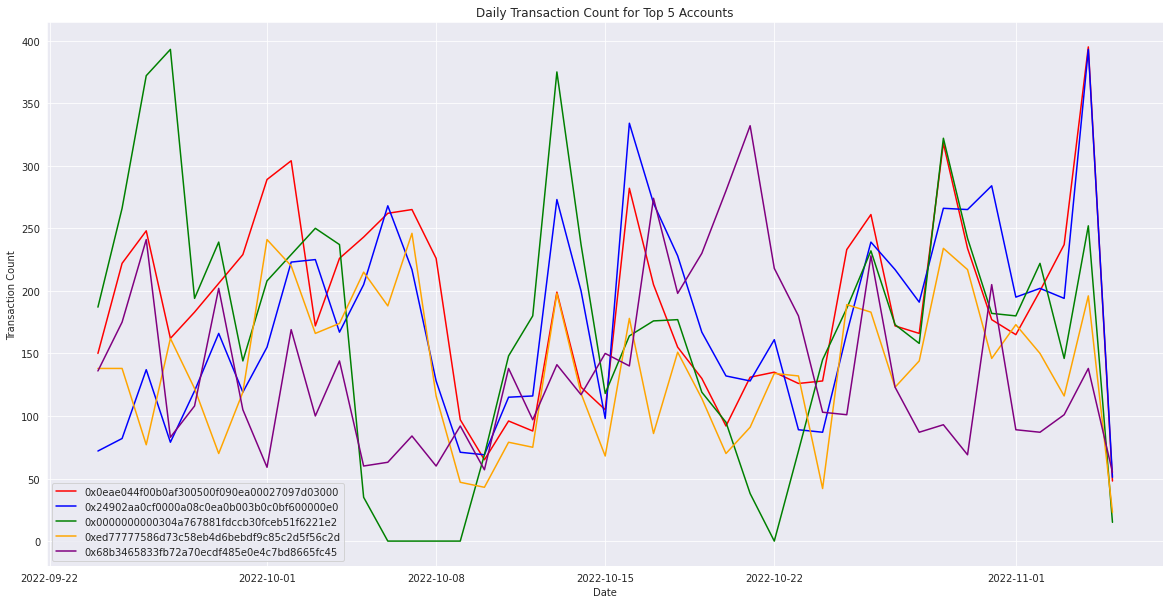

In [42]:
colors = ['red', 'blue', 'green', 'orange', 'purple']

plt.figure(figsize=(20,10))
for i, account_address in enumerate(top_addresses.head(5).index):
    plot_address_activity(_address=account_address, color=colors[i], _column='account_address')

plt.xlabel('Date')
plt.ylabel('Transaction Count')
plt.title('Daily Transaction Count for Top 5 Accounts')
plt.legend(top_addresses.head(5).index, loc='best')
plt.show()

## Time-Series Analysis of Contracts

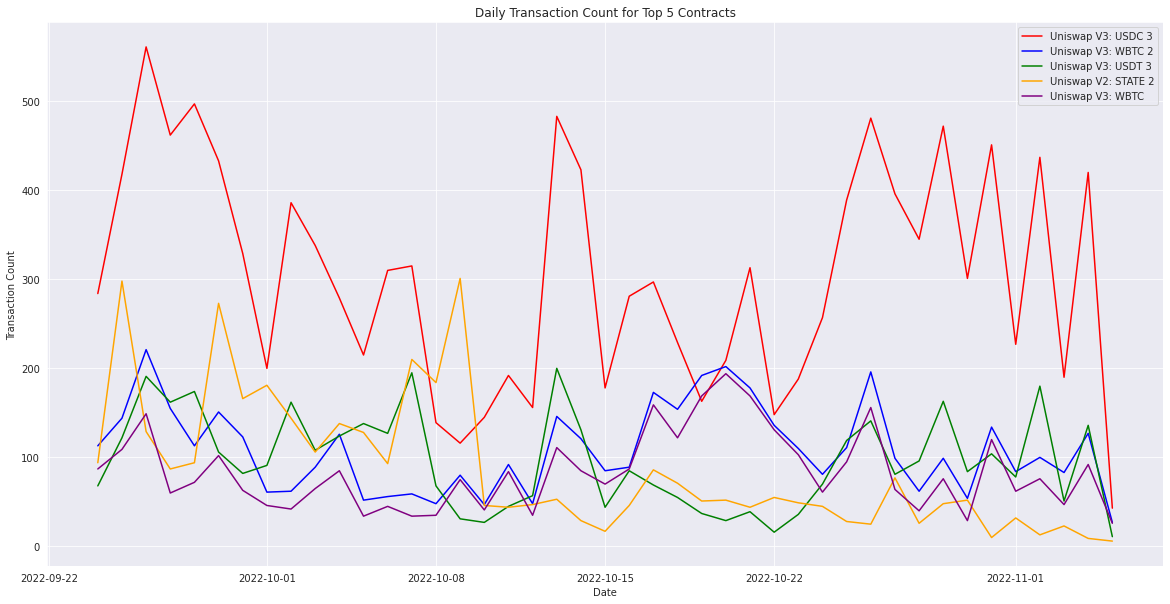

In [43]:
plt.figure(figsize=(20,10))
for i, contract_address in enumerate(most_used_contracts.head(5).index):
    plot_address_activity(_address=contract_address, color=colors[i], _column='contracts_address')

plt.xlabel('Date')
plt.ylabel('Transaction Count')
plt.title('Daily Transaction Count for Top 5 Contracts')
plt.legend(most_used_contracts.index.map(contract_name_tags), loc='best')
plt.show()

## Time-Series Analysis of Tokens

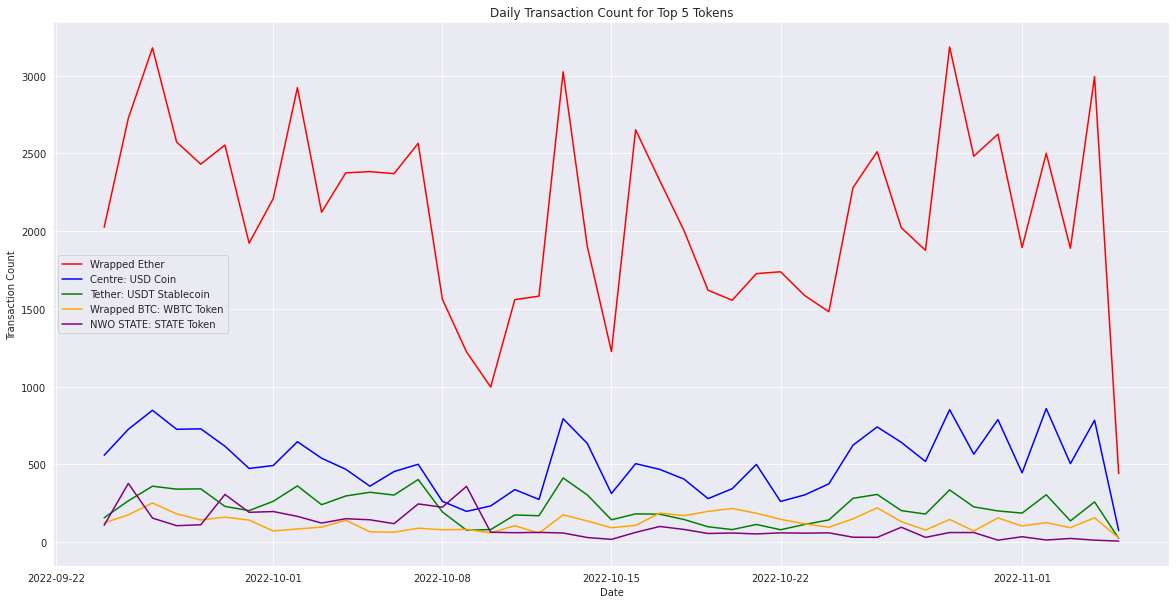

In [44]:
plt.figure(figsize=(20,10))
for i, token_address in enumerate(most_used_tokens.head(5).index):
    plot_address_activity(_address=token_address, color=colors[i], _column='input_tokens_address')

plt.xlabel('Date')
plt.ylabel('Transaction Count')
plt.title('Daily Transaction Count for Top 5 Tokens')
plt.legend(most_used_tokens.index.map(token_name_tags), loc='best')
plt.show()

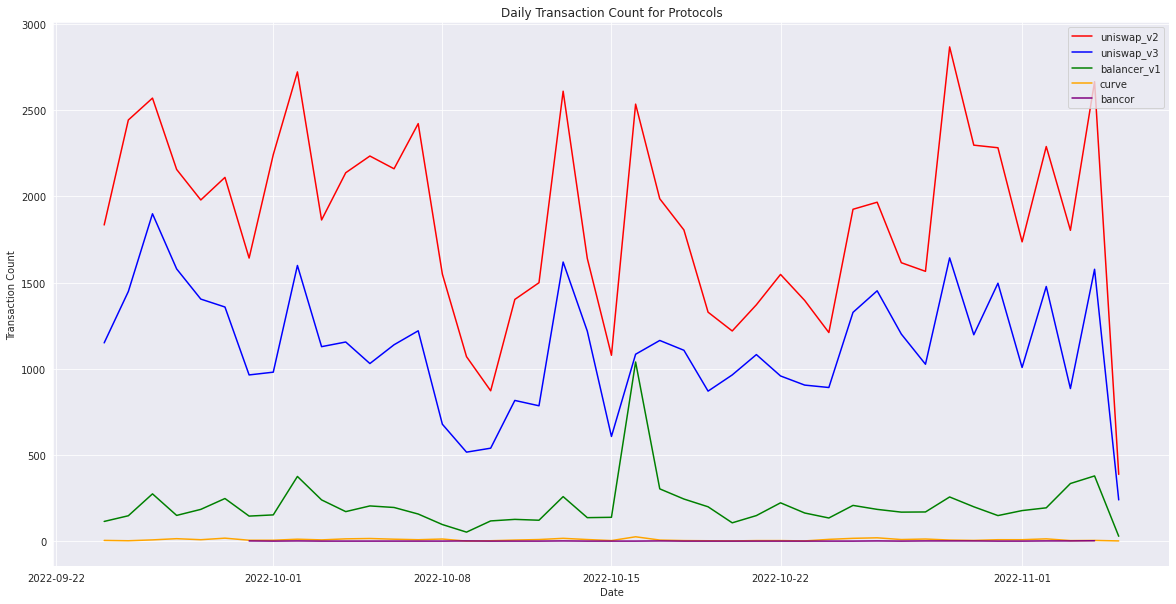

In [45]:
protocols = arb_df['protocols'].str.split(',', expand=True).stack().reset_index(level=1, drop=True).to_frame('protocol')['protocol'].unique()

plt.figure(figsize=(20,10))
for i, protocol in enumerate(protocols):
    plot_address_activity(_address=protocol, color=colors[i], _column='protocols')

plt.xlabel('Date')
plt.ylabel('Transaction Count')
plt.title('Daily Transaction Count for Protocols')
plt.legend(protocols, loc='best')
plt.show()

## Block position

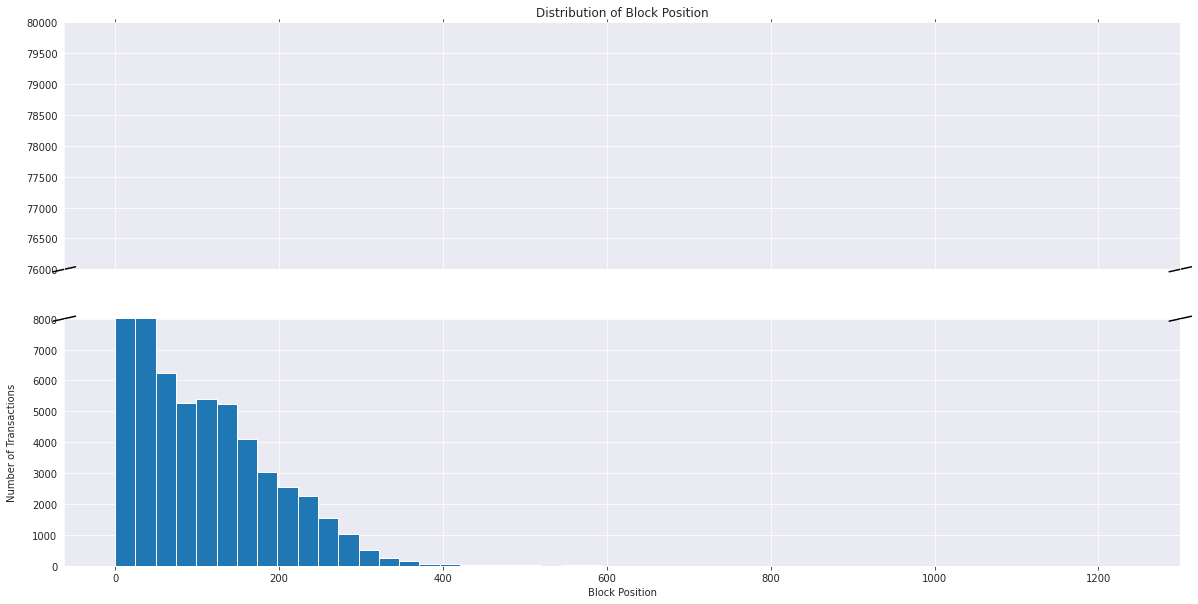

In [46]:
fig, (ax1, ax2) = plt.subplots(2, 1, figsize=(20, 10))

arb_df['block_position'].hist(bins=50, ax=ax1)
arb_df['block_position'].hist(bins=50, ax=ax2)

ax1.set_ylim(20000, 30000)  # outliers only
ax2.set_ylim(0, 12000)  # most of the data

ax1.spines['bottom'].set_visible(False)
ax2.spines['top'].set_visible(False)
ax1.xaxis.tick_top()
ax1.tick_params(labeltop=False)  # don't put tick labels at the top
ax2.xaxis.tick_bottom()

################# Diagonal Lines #################

d = .010  # how big to make the diagonal lines in axes coordinates
kwargs = {'transform':ax1.transAxes, 'color':'k', 'clip_on':False}
ax1.plot((-d, +d), (-d, +d), **kwargs)  # top-left diagonal
ax1.plot((1 - d, 1 + d), (-d, +d), **kwargs)  # top-right diagonal

kwargs.update(transform=ax2.transAxes)  # switch to the bottom axes
ax2.plot((-d, +d), (1 - d, 1 + d), **kwargs)  # bottom-left diagonal
ax2.plot((1 - d, 1 + d), (1 - d, 1 + d), **kwargs)  # bottom-right diagonal

###################################################

ax1.set_title('Distribution of Block Position')

ax2.set_xlabel('Block Position')
ax2.set_ylabel('Number of Transactions', labelpad=15)

plt.show()

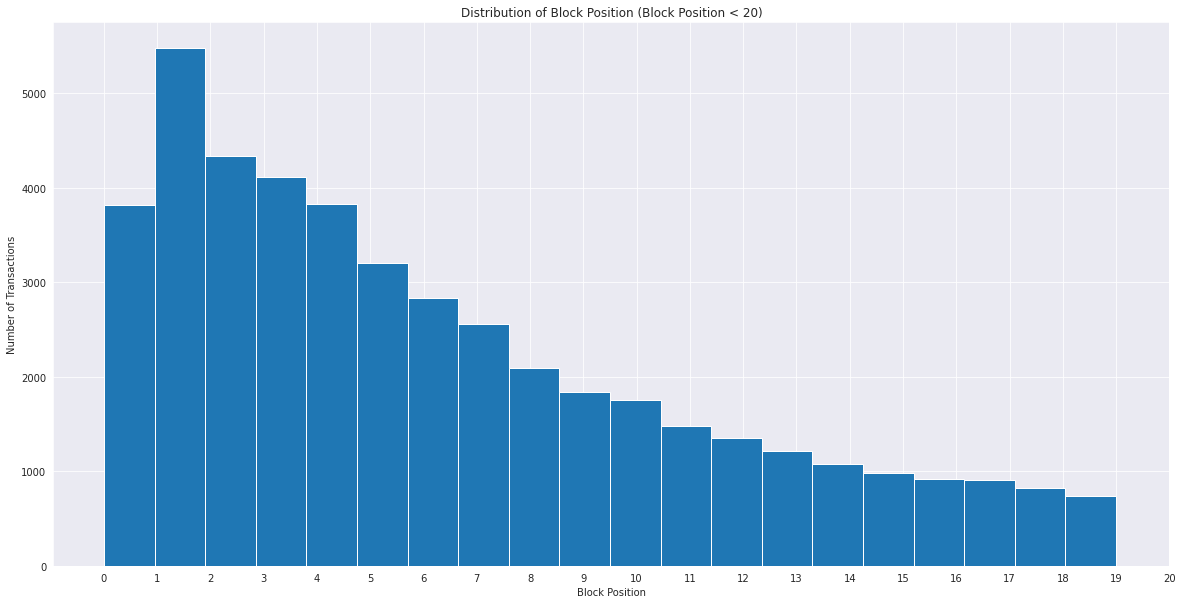

In [47]:
# Filter the data to include only block positions less than 20
filtered_df = arb_df[arb_df['block_position'] < 20]

# Plot the distribution of block_position less than 20 as a histogram
plt.figure(figsize=(20,10))
filtered_df['block_position'].hist(bins=20)
plt.title('Distribution of Block Position (Block Position < 20)')
plt.xlabel('Block Position')
plt.ylabel('Number of Transactions')
plt.xticks(np.arange(21))
plt.show()

## Protocols

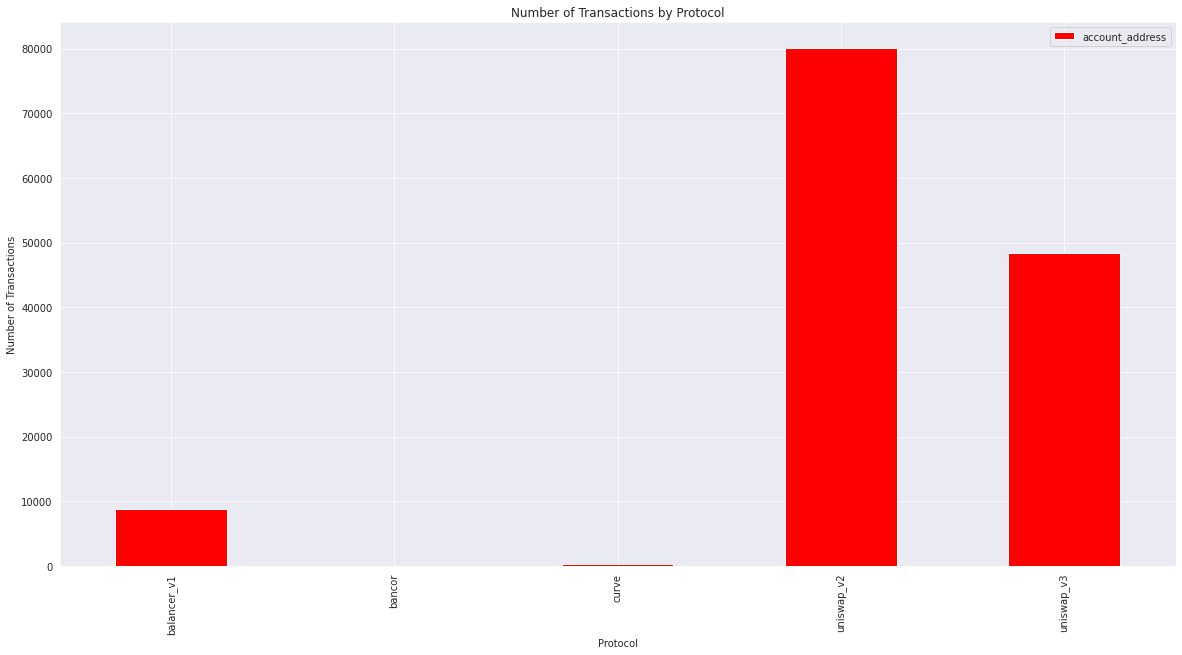

In [48]:
# Parse the protocols column and group by protocol
protocols_df = arb_df['protocols'].str.split(',', expand=True).stack().reset_index(level=1, drop=True).to_frame('protocol')
protocols_df = protocols_df.join(arb_df['account_address'])
protocols_df = protocols_df.groupby(['protocol']).count().reset_index()

# Set the figure size and plot the results as a bar chart
_, ax = plt.subplots(figsize=(20, 10))
protocols_df.plot(x='protocol', y='account_address', kind='bar', color='red', ax=ax)
plt.title('Number of Transactions by Protocol')
plt.xlabel('Protocol')
plt.ylabel('Number of Transactions')
plt.show()

# TODO: normalise based on total # of tx per protocol

# Notes
2. Need to collect some general info on transactions to be able to normalise some datasets
3. Need to check the active addresses and pools?
4. Need to see if there are too many undetected arbitrage transactions or not?
5. What more can I do?
6. Provide the same analysis on liquidations as well!